<a href="https://colab.research.google.com/github/oshodiS/AII/blob/main/project_sho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

# 0. Importing libraries

In [185]:
colab = True

In [184]:
%%capture
if colab:
  !pip install fitter
  !pip install pydot
  !pip install graphviz

In [186]:
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

if colab:
  from fitter import Fitter
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras import layers
  import tensorflow_probability as tfp
  from tensorflow.keras import callbacks

# 1. Load and inspect the dataset

## load data

In [187]:
colab = True
if colab:
    # se con colab
    from pathlib import Path

    from google.colab import drive

    drive.mount('/content/drive')
    data_folder = Path.cwd() / "drive" / "MyDrive" / "A3I" / "data"
    dataset_path = data_folder.joinpath("AMS_descritt_noSM_meltD_adim.csv")
else:
    # se in locale
    dataset_path = "data/AMS_descritt_noSM_meltD_adim.csv"

df = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [188]:
print(df.columns)

to_remove = ['Nome', 'loc', 'scale', '99perc', '95perc', '80perc']
df_cleaned = df.drop(to_remove, axis=1, inplace=False)

df_cleaned.head()

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1,1.221239,28.250000
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1,0.778761,28.250000
2,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,1.219018,33.469565
3,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,0.979995,33.469565
4,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,1.153287,33.469565


In [189]:
# Unique duration values
DURATION = df_cleaned['duration[h]'].unique()
print(DURATION)

[ 1  3  6 12 24]


## 1.1. Preprocess the dataset

In [190]:
# create a dictionary of dataframes, one for each duration
dfs = {}
for duration in DURATION:
    dfs[f'{duration}'] = df_cleaned[df_cleaned['duration[h]'] == duration].drop("duration[h]", axis=1, inplace=False)
    dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [191]:
dfs['3']

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1.106796,51.500000
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,0.893204,51.500000
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1.184466,51.500000
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,496.711703,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,0.815534,51.500000
4,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,245.328628,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,0.876011,53.195652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54923,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,0.946180,37.836364
54924,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,1.009611,37.836364
54925,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,0.459875,37.836364
54926,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,406.218657,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,1.009611,37.836364


In [192]:
# maximum value of AMS in each dataframe
for duration in DURATION:
    print(f"maximum AMS in {duration}h: {dfs[f'{duration}']['AMS'].max()}")

maximum AMS in 1h: 4.782464297575557
maximum AMS in 3h: 4.905896003540713
maximum AMS in 6h: 5.373404747735238
maximum AMS in 12h: 5.915663202234329
maximum AMS in 24h: 6.288661312900612


## scale the columns of the df

In [194]:
def scale_col(df, k = 1, IdD = True, col='AMS'):
    """
        df: dataframe
        k: Multiplication factor to extend the range of AMS values. Defaults to 1.
        IdD: To specify how standardize. Defaults to True.
    """
    for c in col:
      min_AMS = df[c].min() - 1e-3 # to avoid zero values
      max_AMS = df[c].max() * k

      df[c] = df.apply(lambda row: (row[c] - min_AMS) / (max_AMS - min_AMS), axis=1)

    return df

In [195]:
def scale_AMS(df, k = 1, IdD = True):
    """
        df: dataframe
        k: Multiplication factor to extend the range of AMS values. Defaults to 1.
        IdD: To specify how standardize. Defaults to True.
    """
    if IdD:
        df['AMS'] = df.apply(lambda row: row['AMS'] * row['IdD'], axis=1)

    min_AMS = df['AMS'].min() - 1e-3 # to avoid zero values
    max_AMS = df['AMS'].max() * k

    df['AMS'] = df.apply(lambda row: (row['AMS'] - min_AMS) / (max_AMS - min_AMS), axis=1)

    return df

In [218]:
from sklearn.preprocessing import MinMaxScaler

features_not_to_scale = ['ID', 'AMS', 'mean_IdD']
features_to_scale = dfs['1'].columns.drop(features_not_to_scale)

order_columns = ['ID', 'AMS', 'mean_IdD'] + list(features_to_scale)

scaler = MinMaxScaler() #min max scaler to have values in range [0, 1]
std_dfs = {}

for duration in DURATION:
    #scaled_data = dfs[f'{duration}'][features_to_scale]
    scaled_data = scaler.fit_transform(dfs[f'{duration}'][features_to_scale])
    #scaled_data = scale_col(dfs[f'{duration}'][features_to_scale], k = 2, IdD=False, col = features_to_scale)
    non_scaled_data = dfs[f'{duration}'][features_not_to_scale]
    std_dfs[f'{duration}'] = np.concatenate([non_scaled_data, scaled_data], axis=1)

    # convert to dataframe
    std_dfs[f'{duration}'] = pd.DataFrame(std_dfs[f'{duration}'], columns=order_columns)

    # scale AMS
    std_dfs[f'{duration}'] = scale_AMS(std_dfs[f'{duration}'], k=3, IdD = False)

In [219]:
std_dfs['3']

,ID,AMS,mean_IdD,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001.0,0.074305,51.500000,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
1,5001.0,0.059778,51.500000,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
2,5001.0,0.079587,51.500000,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
3,5001.0,0.054495,51.500000,0.401225,0.295914,0.348572,0.226869,0.856073,0.544175,0.304262,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
4,5002.0,0.058609,53.195652,0.162167,0.139318,0.196981,0.203632,0.738690,0.727847,0.462398,...,0.095174,0.256323,0.248748,0.302445,0.445455,0.014482,0.448583,0.065894,0.455494,0.327658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54923,21338.0,0.063381,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
54924,21338.0,0.067695,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
54925,21338.0,0.030307,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
54926,21338.0,0.067695,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423


In [220]:
if colab:
    # colab
    dataset_path = data_folder.joinpath("gumMap_statbench_Gumfit_NEW.csv")
else:
    #  locale
    dataset_path = "data/gumMap_statbench_Gumfit_NEW.csv"

df2 = pd.read_csv(dataset_path, sep=',', encoding='utf-8') #dataset used to extract the ids for test
df2.head()

,Unnamed: 0,ID,Nome,md_1h,md_3h,md_6h,md_12h,md_24h,q1h_0.80,q1h_0.95,...,q_3h_0.99,q_6h_0.80,q_6h_0.95,q_6h_0.99,q_12h_0.80,q_12h_0.95,q_12h_0.99,q_24h_0.80,q_24h_0.95,q_24h_0.99
0,0,5005,'Anzola_Dellemilia',1.0,1.0,1.0,1.0,1.0,1.297268,1.770921,...,2.204652,1.262136,1.679814,2.142859,1.256130,1.664236,2.116671,1.257223,1.667072,2.121439
1,1,5007,'Argelato',1.0,1.0,1.0,1.0,1.0,1.307714,1.798013,...,2.270210,1.272879,1.707674,2.189696,1.264559,1.686097,2.153422,1.257970,1.669008,2.124694
2,2,5015,'Bardi_Centrale',1.0,1.0,1.0,1.0,1.0,1.271656,1.704500,...,2.174044,1.257236,1.667106,2.121495,1.251259,1.651604,2.095435,1.253316,1.656940,2.104405
3,3,5141,'Invaso',1.0,1.0,1.0,1.0,1.0,1.271679,1.704561,...,2.174045,1.257236,1.667106,2.121496,1.251259,1.651605,2.095436,1.253324,1.656960,2.104438
4,4,5143,'Isola_Di_Palanzano_Centrale',1.0,1.0,1.0,1.0,1.0,1.265930,1.689653,...,2.173967,1.257225,1.667077,2.121446,1.251233,1.651538,2.095324,1.250087,1.648565,2.090326


## 1.2. Train-Val-Test split

In [221]:
# Take the first 100 ID from df2 and use them to create the test sets
test_ID = df2['ID'].to_list()[:100]

test_dfs = {}
for duration in DURATION:
    test_dfs[f'{duration}'] = std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)]
    test_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [222]:
# Drop the test set from std_dfs and then create the train sets and validation sets
for duration in DURATION:
    std_dfs[f'{duration}'] = std_dfs[f'{duration}'].drop(std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)].index,)
    std_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

validation_split = 0.1

train_dfs = {}
val_dfs = {}
for duration in DURATION:
    train_dfs[f'{duration}'], val_dfs[f'{duration}'] = train_test_split(std_dfs[f'{duration}'], test_size=validation_split, shuffle=False)
    train_dfs[f'{duration}'].reset_index(drop=True, inplace=True)
    val_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [200]:
train_dfs['3']['mean_IdD']

0        51.500000
1        51.500000
2        51.500000
3        51.500000
4        53.195652
           ...    
46655    19.800000
46656    19.800000
46657    19.800000
46658    19.800000
46659    19.800000
Name: mean_IdD, Length: 46660, dtype: float64

In [223]:
val_dfs['3']

,ID,AMS,mean_IdD,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,20034.0,0.049180,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
1,20034.0,0.056736,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
2,20034.0,0.047806,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
3,20034.0,0.049867,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
4,20034.0,0.085590,19.800000,0.384565,0.399602,0.483928,0.533182,0.530773,0.525270,0.954525,...,0.675218,0.442787,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,21338.0,0.063381,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
5181,21338.0,0.067695,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
5182,21338.0,0.030307,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423
5183,21338.0,0.067695,37.836364,0.011148,0.011932,0.021759,0.068612,0.575490,0.534856,0.150158,...,0.675800,0.146538,0.412679,0.435053,0.251718,0.004974,0.227660,0.028317,0.726106,0.636423


## 1.3. Dataset inspection

#### Timeseries length distribution for each duration, both for training and validation

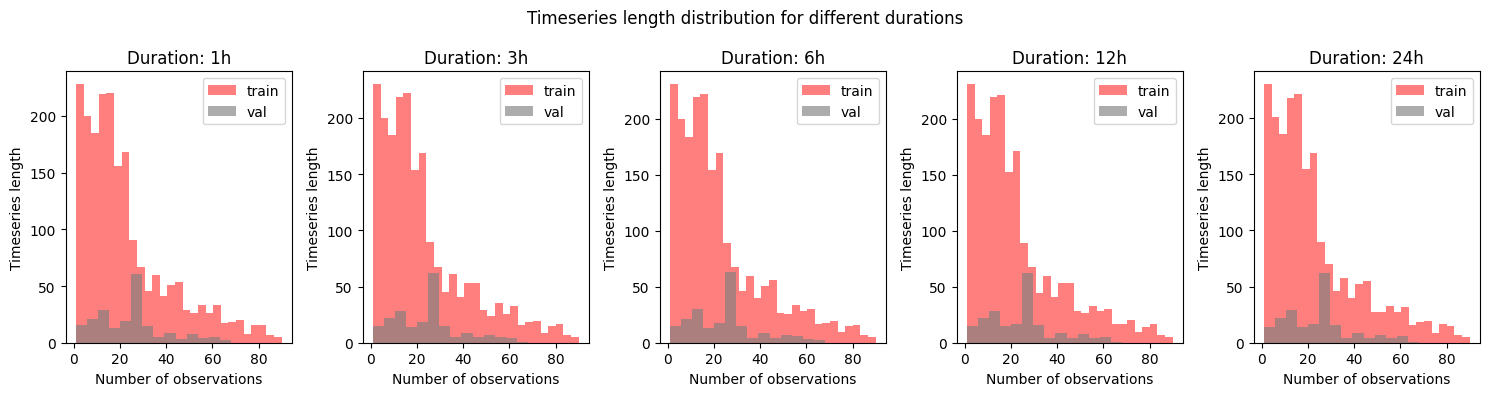

In [224]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns
fig.suptitle("Timeseries length distribution for different durations")

for i, duration in enumerate(DURATION):
    ax = axes[i]
    ax.hist(train_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.5, label='train', color='red')
    ax.hist(val_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.65, label='val', color='gray')
    ax.legend()
    ax.set_title(f"Duration: {duration}h")
    ax.set_xlabel("Number of observations")
    ax.set_ylabel("Timeseries length")

plt.tight_layout()
plt.show()

### MAP distribution for training and validation

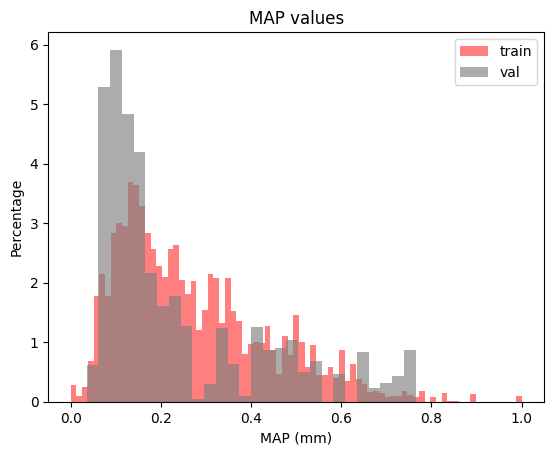

In [225]:
plt.hist(train_dfs['3']['MAP(mm)'], bins='auto', alpha=0.5, label='train', density=True, color='red')
plt.hist(val_dfs['3']['MAP(mm)'], bins='auto', alpha=0.65, label='val', density=True, color='gray')
plt.ylabel('Percentage')
plt.title('MAP values')
plt.xlabel('MAP (mm)')
plt.legend()
plt.show()

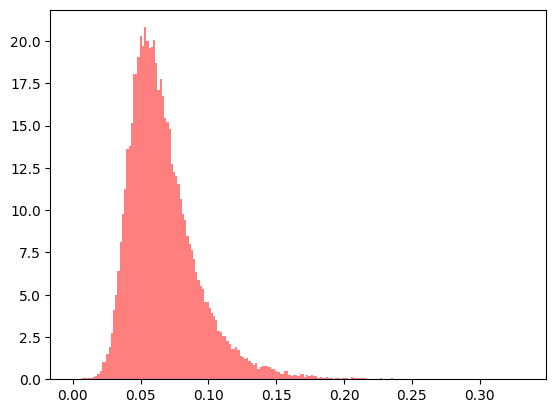

In [226]:
# plot the distribution of ams for duration '3'
ams_3 = train_dfs['3']['AMS']

#plot the histogram
plt.hist(ams_3, bins='auto', alpha=0.5, label='train', density=True, color='red');

2024-02-08 15:20:25.789 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=89.235493)
2024-02-08 15:20:25.806 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=408.311153)
2024-02-08 15:20:25.823 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=3119.017556)
2024-02-08 15:20:26.440 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=97.244026)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,89.235493,884.326500,910.578427,inf,0.042836,7.806371e-75
beta,97.244026,960.694372,995.696943,inf,0.045380,6.165061e-84
norm,408.311153,2200.136185,2217.637470,inf,0.092472,0.000000e+00
uniform,3119.017556,-216.151772,-198.650487,inf,0.606170,0.000000e+00


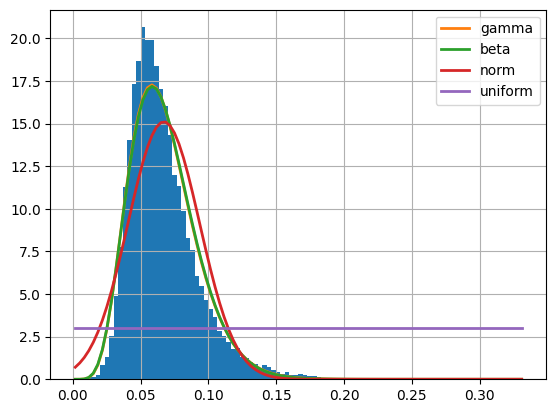

In [227]:
#Fit distribution
f = Fitter(ams_3, distributions=['beta', 'gamma', 'norm', 'uniform'])
f.fit()
f.summary()

In [228]:
# take the best params for the beta distribution to use as initial guesses
a_guess, b_guess, loc, scale  = f.fitted_param['beta']
print("alpha: ", a_guess)
print("beta: ", b_guess)

alpha:  7.254824519423679
beta:  175.9860633806012


## prepare data for training

In [229]:
print(train_dfs['3'].columns)

Index(['ID', 'AMS', 'mean_IdD', 'HMerit_mean(m)', 'HMerit_stdev(m)',
       'Slope_mean(deg)', 'Slope_stdev(deg)', 'Aspect_mean(deg)',
       'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)',
       'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)',
       'OrograTirr_mean(m)', 'OrograTirr_stdev(m)', 'OrograTirr_max(m)',
       'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [230]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_dfs['1'].columns
input_columns = columns[3:]
output_column = 'AMS'
print('Input columns: ', input_columns)

Input columns:  Index(['HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [231]:
inputs_train = {}
outputs_train = {}
for duration in DURATION:
    inputs_train[f'{duration}'] = train_dfs[f'{duration}'][input_columns]
    outputs_train[f'{duration}'] = train_dfs[f'{duration}'][output_column]

inputs_val = {}
outputs_val = {}
for duration in DURATION:
    inputs_val[f'{duration}'] = val_dfs[f'{duration}'][input_columns]
    outputs_val[f'{duration}'] = val_dfs[f'{duration}'][output_column]

In [232]:
inputs_train['3'].values.max()

1.0000000000000002

# 2. Model definition

In [233]:
# create a custom train loop to train the model
def train_model(model, train_dataset, optimizer, epochs, batch_size, loss_fn):
    for epoch in range(epochs):
        print(f"\nStart of Training Epoch {epoch + 1}")

        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                tape.watch(model.trainable_weights)

                try:
                  y_pred = model(x_batch_train, training=True)
                except:
                  print('ERRORE in ', step)
                  print('Trainable weights:')
                  print(model.trainable_weights)
                  print('^^^^^^^^^X, y^^^^^^^^^^^')
                  print(x_batch_train, y_batch_train)
                  print('LOSS: ', loss)
                loss = loss_fn(tf.cast(y_batch_train, tf.float32), y_pred)

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        print('loss: ', np.mean(loss))

#### Bias model + loglikelohood loss



In [234]:
inputs_train['3'].values.max()

1.0000000000000002

In [235]:
max(np.array(inputs_train['3'].values))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
inputs_train.valesu

X_train = inputs_train['3'].values
y_train  = outputs_train['3'].values

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)

epochs = 5
loss_fn = lambda y_true, dist: -dist.log_prob(y_true)
optimizer=keras.optimizers.Adam(learning_rate=1e-2)
model = build_nn_beta_model_bias(input_shape=(20,), hidden=[], alpha_guess=a_guess, beta_guess=b_guess)
train_model(model, train_dataset, optimizer, epochs, batch_size, loss_fn)

In [ ]:
def build_nn_beta_model(input_shape, hidden, alpha_guess=1, beta_guess=1):
    alpha_guess = np.log(alpha_guess)
    beta_guess = np.log(beta_guess)

    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
        x = layers.BatchNormalization()(x)

    bias_initializer = tf.keras.initializers.Constant([1, 1])
    alpha_beta = layers.Dense(2, activation='relu', bias_initializer=bias_initializer)(x)

    lf = lambda t: tfp.distributions.Beta(concentration0=tf.math.exp(t[:,1:2]), concentration1=tf.math.exp(t[:,0:1]), validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

Epoch 1/10
1459/1459 [==============================] - 8s 5ms/step - loss: 1.5232 - val_loss: 0.8063
Epoch 2/10
1459/1459 [==============================] - 6s 4ms/step - loss: 1.5232 - val_loss: 0.8063
Epoch 3/10
1459/1459 [==============================] - 6s 4ms/step - loss: 1.5232 - val_loss: 0.8063
Epoch 4/10
1459/1459 [==============================] - 6s 4ms/step - loss: 1.5232 - val_loss: 0.8063
Epoch 5/10
1459/1459 [==============================] - 6s 4ms/step - loss: 1.5232 - val_loss: 0.8063
Epoch 6/10
1459/1459 [==============================] - 7s 5ms/step - loss: 1.5232 - val_loss: 0.8063
Epoch 7/10
1459/1459 [==============================] - 6s 4ms/step - loss: 1.5232 - val_loss: 0.8063
Epoch 8/10
1459/1459 [==============================] - 7s 5ms/step - loss: 1.5232 - val_loss: 0.8063
Epoch 9/10
1459/1459 [==============================] - 6s 4ms/step - loss: 1.5232 - val_loss: 0.8063
Epoch 10/10
1459/1459 [==============================] - 7s 5ms/step - loss: 1.523

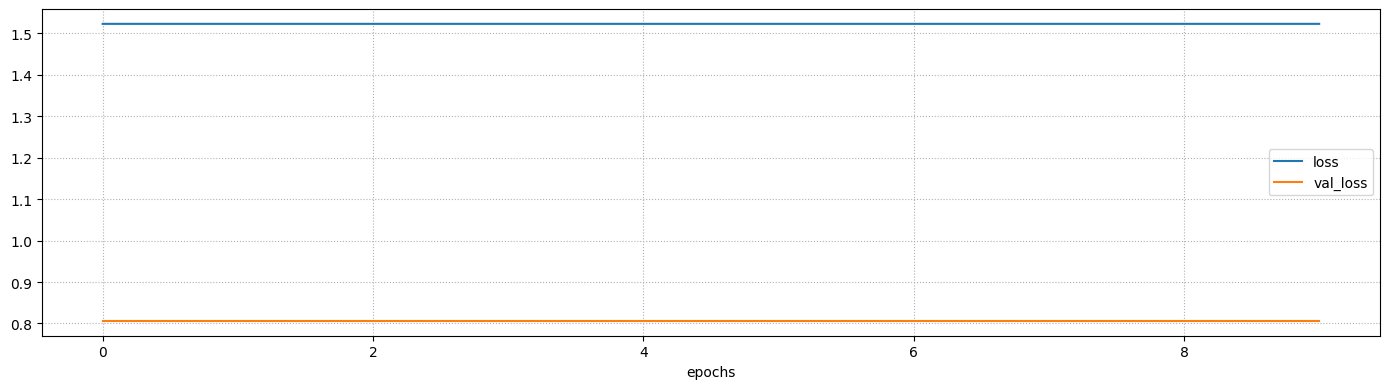

Final loss: 1.5232 (training), 0.8063 (validation)


In [236]:
def train_nn_model(model, X, y, batch_size, loss, verbose=0, patience=10, validation_data=None, optimizer='Adam', **fit_params):
    # Compile the model
    model.compile(optimizer=optimizer, loss=loss)
    # Build the early stop callback
    cb = []
    if validation_split is not None:
        cb += [callbacks.EarlyStopping(patience=patience,
            restore_best_weights=True)]
    # Train the model
    history = model.fit(X, y, batch_size=batch_size, callbacks=cb,
            validation_data=validation_data,
            verbose=verbose, **fit_params)
    return history

def plot_training_history(history=None,
        figsize=None, print_final_scores=True):
    plt.figure(figsize=figsize)
    for metric in history.history.keys():
        plt.plot(history.history[metric], label=metric)
    # if 'val_loss' in history.history.keys():
    #     plt.plot(history.history['val_loss'], label='val. loss')
    if len(history.history.keys()) > 0:
        plt.legend()
    plt.xlabel('epochs')
    plt.grid(linestyle=':')
    plt.tight_layout()
    plt.show()
    if print_final_scores:
        trl = history.history["loss"][-1]
        s = f'Final loss: {trl:.4f} (training)'
        if 'val_loss' in history.history:
            vll = history.history["val_loss"][-1]
            s += f', {vll:.4f} (validation)'
        print(s)

X_train = inputs_train['3'].values
y_train  = outputs_train['3'].values
X_val = inputs_val['3'].values
y_val = outputs_val['3'].values

batch_size = 32
epochs = 10
loss_fn = lambda y_true, dist: -dist.log_prob(y_true)
optimizer=keras.optimizers.Adam(learning_rate = 1e-20)
model = build_nn_beta_model(input_shape=(20,), hidden=[], alpha_guess=a_guess, beta_guess=b_guess)
history = train_nn_model(model, X_train, y_train, batch_size, loss_fn, verbose=1, patience=10, validation_data=(X_val,y_val), epochs=epochs, optimizer = optimizer)
plot_training_history(history, figsize=(14,4))


# Predictions

In [150]:
from sklearn import metrics
def plot_pred_scatter(y_true, y_pred, figsize=None, print_metrics=True):
    plt.figure(figsize=figsize)
    plt.scatter(y_pred, y_true, marker='.', alpha=0.1)
    xl, xu = plt.xlim()
    yl, yu = plt.ylim()
    l, u = min(xl, yl), max(xu, yu)
    plt.plot([l, u], [l, u], ':', c='0.3')
    plt.grid(linestyle=':')
    plt.xlim(l, u)
    plt.ylim(l, u)
    plt.xlabel('prediction')
    plt.ylabel('target')
    plt.tight_layout()

    if print_metrics:
        print(f'R2: {metrics.r2_score(y_true, y_pred):.2f}')
        print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred):.2f}')

In [241]:
b_guess


175.9860633806012

In [239]:
model(X_train).concentration1

<tf.Tensor: shape=(46660, 1), dtype=float32, numpy=
array([[2.5779135],
       [2.5779135],
       [2.5779135],
       ...,
       [1.8695157],
       [1.8695157],
       [1.8695157]], dtype=float32)>

In [243]:
model(X_train).concentration1

<tf.Tensor: shape=(46660, 1), dtype=float32, numpy=
array([[2.5779135],
       [2.5779135],
       [2.5779135],
       ...,
       [1.8695157],
       [1.8695157],
       [1.8695157]], dtype=float32)>

R2: -191.63
MAE: 0.35


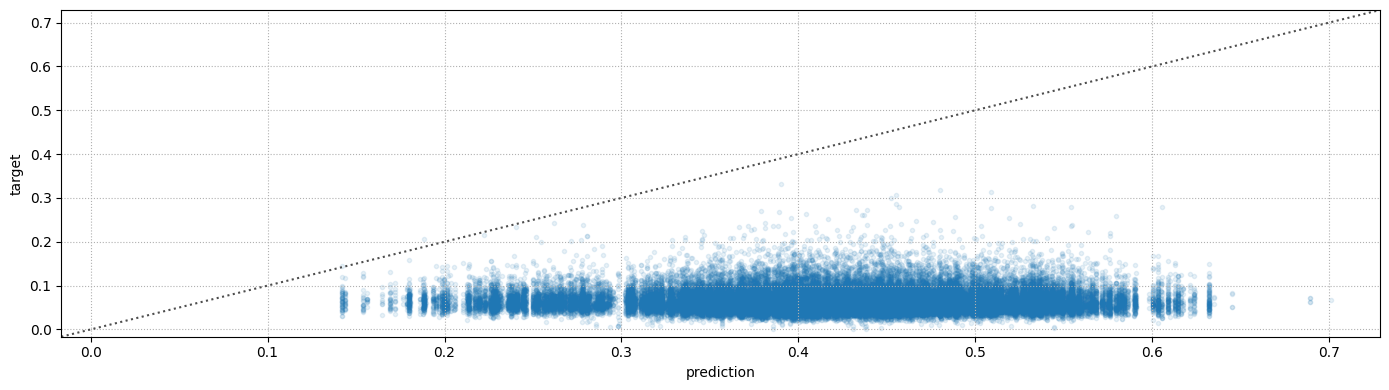

In [245]:
# questo plot è con: Bias model + loglikelohood loss
tr_pred = model(X_train).mean().numpy().ravel()
plot_pred_scatter(y_train, tr_pred, figsize=(14,4))

In [ ]:
tr_pred

In [249]:
len(y_train)

46660

In [252]:
model(X_train).

AttributeError: 'Beta' object has no attribute 'values'